Information sur les GPU disponible

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Sun Jan 19 09:40:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Téléchargement des librairies manquantes

In [ ]:
!pip install jsonlines
!pip install cairocffi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.3 MB/s eta 0:00:00


# Importation of the librairie

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import jsonlines
import cv2
import cairocffi as cairo
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

Sélection du device pour bien utiliser le GPU avec cuda

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data Loading


Chargement des datasets dans un dataframe commun

In [ ]:
import jsonlines
import pandas as pd
import numpy as np
import cairocffi as cairo
import matplotlib.pyplot as plt

# Fonction pour charger les fichiers NDJSON
def load_ndjson_files(filenames):
    """Loads multiple NDJSON files into a single pandas DataFrame."""
    try:
        all_data = []
        for filename in filenames:
            with jsonlines.open(filename) as reader:
                for obj in reader:
                    all_data.append(obj)
        return pd.DataFrame(all_data)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Chargement des fichiers NDJSON
filenames = [
    '/content/drive/MyDrive/Quickdraw/datasets/full_simplified_airplane.ndjson',
    '/content/drive/MyDrive/Quickdraw/datasets/full_simplified_backpack.ndjson',
    '/content/drive/MyDrive/Quickdraw/datasets/full_simplified_car.ndjson',
    '/content/drive/MyDrive/Quickdraw/datasets/full_simplified_coffee cup.ndjson',
    '/content/drive/MyDrive/Quickdraw/datasets/full_simplified_sailboat.ndjson'
]
data = load_ndjson_files(filenames)

# Vérification des données chargées
if data is not None:
    print(data.head())

       word countrycode                      timestamp  recognized  \
0  airplane          US  2017-03-08 21:12:07.26604 UTC        True   
1  airplane          CA  2017-03-06 21:39:04.69013 UTC       False   
2  airplane          US  2017-03-23 02:08:35.22998 UTC        True   
3  airplane          US  2017-03-10 00:35:17.53197 UTC        True   
4  airplane          IL  2017-01-23 18:11:11.65817 UTC        True   

             key_id                                            drawing  
0  5152802093400064  [[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...  
1  6622904974311424  [[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...  
2  6577010312740864  [[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...  
3  5643224746033152  [[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...  
4  6670046841536512  [[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...  


# Preprocessing des data

On va dans un premier temps transformer les traits du dessin en une image réelle pour cela on utilise la fonction donnée dans le github de quickdraw ce qui permet d'avoir à la fin une image de taille 112x112

In [ ]:
def vector_to_raster(vector_images, side=56, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """

    original_side = 256.

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()

        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)

    return raster_images


In [ ]:
data['raster_2'] = vector_to_raster(data['drawing'])

In [ ]:
data['raster_2'].iloc[0].shape

(3136,)

Représentation de l'image en 56x56

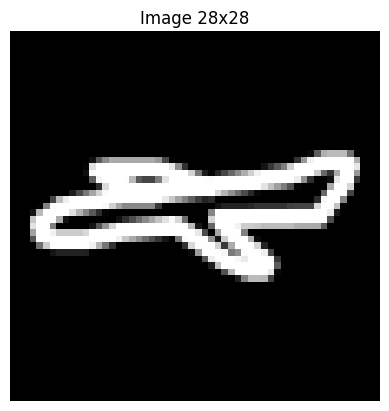

In [ ]:
# Affichage d'un exemple d'image
# Reshape en 28x28
image_2d = data['raster_2'].iloc[7].reshape((56, 56))

# Afficher l'image
plt.imshow(image_2d, cmap='gray')  # 'gray' pour une échelle de gris
plt.title("Image 28x28")
plt.axis('off')  # Supprimer les axes
plt.show()

Nous allons ensuite terminer la phase de prétraitement en supprimant les colonnes non nécessaire et aussi en créant les dataloader pour les différents jeu de donnée

In [ ]:
# Print the dataset informations
if data is not None:
  print(data.head())
  print(data.columns)

       word countrycode                      timestamp  recognized  \
0  airplane          US  2017-03-08 21:12:07.26604 UTC        True   
1  airplane          CA  2017-03-06 21:39:04.69013 UTC       False   
2  airplane          US  2017-03-23 02:08:35.22998 UTC        True   
3  airplane          US  2017-03-10 00:35:17.53197 UTC        True   
4  airplane          IL  2017-01-23 18:11:11.65817 UTC        True   

             key_id                                            drawing  \
0  5152802093400064  [[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...   
1  6622904974311424  [[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...   
2  6577010312740864  [[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...   
3  5643224746033152  [[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...   
4  6670046841536512  [[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...   

                                            raster_2  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Drop out the non necessary columns
data_prepro = data.drop(['countrycode', 'timestamp', 'key_id', 'drawing'], axis=1)
print(data_prepro.head())

       word  recognized                                           raster_2
0  airplane        True  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  airplane       False  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2  airplane        True  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3  airplane        True  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  airplane        True  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [ ]:
# Removing the row with recognized==False
if data_prepro is not None:
    # Group by 'word' and count the number of each word
    word_counts = data_prepro.groupby('word').count()
    print("\nNumber of lines per word:\n", word_counts)

    # 'recognized' column indicates whether a word was recognized (True/False or 1/0)
    if 'recognized' in data_prepro.columns:
        recognized_counts = data_prepro.groupby('word')['recognized'].sum()
        print("\nNumber of recognized words per word:\n", recognized_counts)

        # Remove rows where 'recognized' is False
        final_data = data_prepro[data_prepro['recognized'] == True].drop(['recognized'], axis=1)  # or df[df['recognized'] == 1] if it's numeric
        print("\nDataFrame after removing rows with 'recognized' as False:\n", final_data.head())


Number of lines per word:
             recognized  raster_2
word                            
airplane        151623    151623
backpack        125801    125801
car             182764    182764
coffee cup      183432    183432
sailboat        136506    136506

Number of recognized words per word:
 word
airplane      135823
backpack      118110
car           160789
coffee cup    161463
sailboat      132270
Name: recognized, dtype: int64

DataFrame after removing rows with 'recognized' as False:
        word                                           raster_2
0  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 708455 entries, 0 to 780125
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   word      708455 non-null  object
 1   raster_2  708455 non-null  object
dtypes: object(2)
memory usage: 16.2+ MB


In [ ]:
# Shuffle the rows of the DataFrame
final_data = final_data.sample(frac=1).reset_index(drop=True)
print(final_data.head())

       word                                           raster_2
0  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  backpack  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       car  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       car  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  airplane  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


On sélectionne les images et les labels que l'on stocke dans des array

In [ ]:
# Convertir les dessins en images
images = []
labels = []

for index, row in final_data.iterrows():
    img = row['raster_2']
    images.append(img)
    labels.append(row['word'])

images = np.array(images)
labels = np.array(labels)

In [ ]:
print(images.shape, labels.shape)

(708455, 3136) (708455,)


Création des différents jeu de donnée

In [ ]:
# Diviser les données en ensembles d'entraînement, de validation et de test
train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

In [ ]:
print(f"Taille de l'ensemble d'entraînement : {len(train_images)}")
print(f"Taille de l'ensemble de validation : {len(val_images)}")
print(f"Taille de l'ensemble de test : {len(test_images)}")

Taille de l'ensemble d'entraînement : 495918
Taille de l'ensemble de validation : 106268
Taille de l'ensemble de test : 106269


Transformation en tensor et normalisation des données

In [ ]:
# Normaliser les images et convertir en tenseurs PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def preprocess_image(image):
    # Vérifier que l'image est de dimension correcte
    if image.ndim == 1:
        # Reshape en 56x56 si c'est un tableau plat
        image = image.reshape((56, 56))
    elif image.ndim != 2:
        raise ValueError(f"L'image doit être 2D ou 1D (plat). Dimensions actuelles : {image.shape}")
    image = image.astype(np.float32) / 255.0
    image = transform(image)
    return image

In [ ]:
train_images = [preprocess_image(img) for img in train_images]
val_images = [preprocess_image(img) for img in val_images]
test_images = [preprocess_image(img) for img in test_images]

In [ ]:
print(train_images[0].shape)

torch.Size([1, 56, 56])


Création des Datasets et DataLoader pour les différents jeu

In [ ]:
# Créer des DataLoaders
train_dataset = TensorDataset(torch.stack(train_images))
val_dataset = TensorDataset(torch.stack(val_images))
test_dataset = TensorDataset(torch.stack(test_images))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model GAN

## Definition of the model

Définition du génerateur et du discriminateur

In [ ]:
# Définir le générateur
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 1024), ## adding this block
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [ ]:
# Définir le discriminateur
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

Définition des hyperparamètres

In [ ]:
# Initialiser les hyperparamètres
latent_dim = 100
img_shape = (1, 56, 56)
lr = 0.0002
n_epochs = 5

# Initialiser les modèles
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

# Initialiser les optimiseurs
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Fonction de perte
adversarial_loss = torch.nn.BCELoss()

# Initialiser les listes pour stocker les pertes
g_losses = []
d_losses = []

In [ ]:
n_epochs = 2

Chargement du modèle

In [ ]:
generator.load_state_dict(torch.load('/content/drive/MyDrive/Quickdraw/models/generator_model_2.h5'))  # Chargez le fichier du modèle

## Train of the model

Entrainement du modèle GAN

In [ ]:
print(device)
# Boucle d'entraînement
for epoch in range(n_epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    for i, (imgs,) in enumerate(train_loader):
        # Put the models on the device
        generator.to(device)
        discriminator.to(device)
        imgs = imgs.to(device)
        # Étiquettes
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)

        # Entraînement du générateur
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Entraînement du discriminateur
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        #if (i % 2 ==0): pour aider le génerateur à tromper le discriminateur
        d_loss.backward()
        optimizer_D.step()

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if i % 100 == 0:
          print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
          d_losses.append(d_loss_epoch / 100)
          g_losses.append(g_loss_epoch / 100)
          d_loss_epoch = 0
          g_loss_epoch = 0

    print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    if epoch % 1 == 0:
        save_image(gen_imgs.data[:25], f"/content/drive/MyDrive/Quickdraw/images/GAN_3/{epoch}.png", nrow=5, normalize=True)


cuda
[Epoch 0/20] [Batch 0/7749] [D loss: 0.3857525587081909] [G loss: 0.8591572642326355]
[Epoch 0/20] [Batch 100/7749] [D loss: 1.2296578884124756] [G loss: 0.10215647518634796]
[Epoch 0/20] [Batch 200/7749] [D loss: 0.40759098529815674] [G loss: 0.9615588784217834]
[Epoch 0/20] [Batch 300/7749] [D loss: 0.39593490958213806] [G loss: 0.8654953241348267]
[Epoch 0/20] [Batch 400/7749] [D loss: 0.39413559436798096] [G loss: 1.4987874031066895]
[Epoch 0/20] [Batch 500/7749] [D loss: 0.3517863154411316] [G loss: 0.8940293788909912]
[Epoch 0/20] [Batch 600/7749] [D loss: 0.34647372364997864] [G loss: 1.3011548519134521]
[Epoch 0/20] [Batch 700/7749] [D loss: 0.4036479592323303] [G loss: 1.221622109413147]
[Epoch 0/20] [Batch 800/7749] [D loss: 0.5675961971282959] [G loss: 0.49806779623031616]
[Epoch 0/20] [Batch 900/7749] [D loss: 0.35476380586624146] [G loss: 1.2391847372055054]
[Epoch 0/20] [Batch 1000/7749] [D loss: 0.4117994010448456] [G loss: 0.9899312257766724]
[Epoch 0/20] [Batch 11

Affichage de la courbe de loss

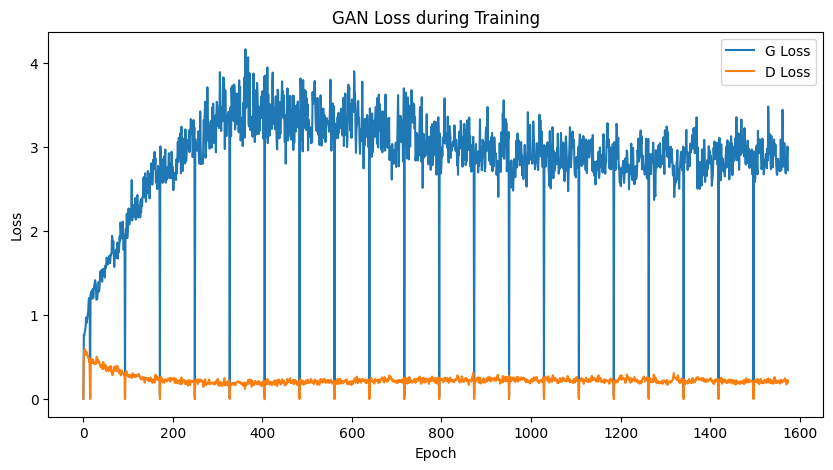

In [ ]:
# Tracer les courbes de perte
plt.figure(figsize=(10, 5))
plt.title("GAN Loss during Training")
plt.plot(g_losses, label="G Loss")
plt.plot(d_losses, label="D Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Génération d'image à l'aide du GAN

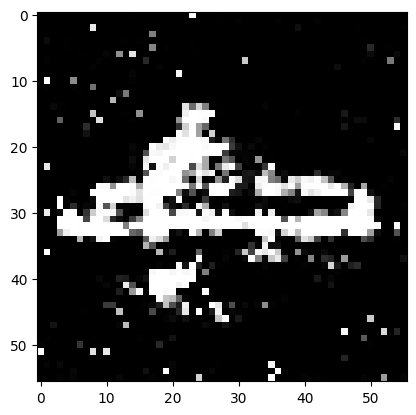

In [ ]:
generator.eval()
z = torch.randn(1, latent_dim).to(device)
gen_imgs = generator(z)
plt.imshow(gen_imgs.detach().cpu().numpy()[0][0], cmap='gray')
plt.show()

Sauvegarde du génerateur et du discriminateur

In [ ]:
# Save the generator model
torch.save(generator.state_dict(), '/content/drive/MyDrive/Quickdraw/models/generator_model_3.h5')

# Save the discriminator model (optional, but recommended)
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/Quickdraw/models/discriminator_model_3.h5')

# Model VAE

# Preprocess des données

In [ ]:
# Calculate the index to split the data
split_index = int(0.25 * len(images))

# Split the data
images = images[:split_index]
labels = labels[:split_index]

print(images.shape, labels.shape)

(177113, 3136) (177113,)


In [ ]:
from collections import Counter

# Assuming 'labels' is your NumPy array of labels
label_counts = Counter(labels)

# Print the counts for each label
for label, count in label_counts.items():
    print(f"Label '{label}': {count} occurrences")

Label 'airplane': 34049 occurrences
Label 'backpack': 29578 occurrences
Label 'car': 40049 occurrences
Label 'sailboat': 32965 occurrences
Label 'coffee cup': 40472 occurrences


In [ ]:
# On va reprendre les array images et labels de la partie préprocess du GAN
# Diviser les données en ensembles d'entraînement, de validation et de test
data_train_val, data_test, labels_train_val, labels_test = train_test_split(images, labels, test_size=0.15, stratify=labels, random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(data_train_val, labels_train_val, test_size=0.1765, stratify=labels_train_val, random_state=42)

In [ ]:
# Vérification des tailles des ensembles
print(f"Taille de l'ensemble d'entraînement : {len(data_train)}")
print(f"Taille de l'ensemble de validation : {len(data_val)}")
print(f"Taille de l'ensemble de test : {len(data_test)}")

Taille de l'ensemble d'entraînement : 123974
Taille de l'ensemble de validation : 26572
Taille de l'ensemble de test : 26567


In [ ]:
labels_train

array(['coffee cup', 'sailboat', 'airplane', ..., 'coffee cup', 'car',
       'backpack'], dtype='<U10')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Conversion des étiquettes en indices numériques
train_labels_encoded = label_encoder.fit_transform(labels_train)
val_labels_encoded = label_encoder.transform(labels_val)
test_labels_encoded = label_encoder.transform(labels_test)

In [ ]:
# Affichage des étiquettes encodées
print(train_labels_encoded)

[3 4 0 ... 3 2 1]


In [ ]:
# Convertir les étiquettes en vecteurs one-hot
num_classes = len(label_encoder.classes_)  # Nombre de classes

train_labels_one_hot = np.eye(num_classes)[train_labels_encoded]
val_labels_one_hot = np.eye(num_classes)[val_labels_encoded]
test_labels_one_hot = np.eye(num_classes)[test_labels_encoded]


In [ ]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
data_train[0].shape

(3136,)

In [124]:
transform_cVAE = transforms.Compose([
    transforms.ToTensor(),
])

def preprocess_image_cVAE(image):
    image = image.reshape((56, 56))
    image = image.astype(np.float32) / 255.0
    image = torch.tensor(image, dtype=torch.float32)
    return image

In [125]:
data_train.shape

(123974, 3136)

In [126]:
data_train_VAE = [preprocess_image_cVAE(img) for img in data_train]

In [159]:
test_images_VAE = [preprocess_image_cVAE(img) for img in data_test]

In [129]:
# Convert NumPy arrays to PyTorch tensors
data_train_VAE = torch.stack(data_train_VAE)
train_label_one_hot = torch.tensor(train_labels_one_hot, dtype=torch.float32)

In [160]:
# Convert NumPy arrays to PyTorch tensors
data_test_VAE = torch.stack(test_images_VAE)
test_label_one_hot = torch.tensor(test_labels_one_hot, dtype=torch.float32)

In [130]:
data_train_VAE.shape, train_label_one_hot.shape

(torch.Size([123974, 56, 56]), torch.Size([123974, 5]))

In [161]:
data_test_VAE.shape, test_label_one_hot.shape

(torch.Size([26567, 56, 56]), torch.Size([26567, 5]))

In [131]:
# Création du dataset et dataloader pour la parti train
train_dataset = TensorDataset(data_train_VAE, train_label_one_hot)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [162]:
# Création du dataset et dataloader pour la parti test
test_dataset = TensorDataset(data_test_VAE, test_label_one_hot)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [132]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([56, 56]), torch.Size([5]))

## Definition of the model

In [144]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        '''
        x: (bs, feature_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [134]:
def loss_function(recon_x, x, mu, logvar):
    reconst_loss = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconst_loss + KLD

Définition des hyperparamètres

In [175]:
# Hyperparameters
input_dim = 56 * 56  # Input image dimensions (56x56)
latent_dim = 20  # Dimensionality of the latent space
num_classes = len(label_encoder.classes_) # Number of classes
lr = 1e-3 # Learning rate
n_epochs = 10 # Number of training epochs
batch_size = 64 # Batch size for training

Initialisation du modèle

In [151]:
# Initialize the CVAE model
model = CVAE(input_dim, latent_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# Initialiser les listes pour stocker les pertes
losses = []

## Train of the model

Fonction d'entrainement

In [180]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        data = data.view(data.size(0), -1)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    losses.append(train_loss / len(train_loader.dataset))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

Entrainement du modèle

In [191]:
for epoch in range(1, n_epochs + 1):
        train(epoch)

Train Epoch: 1 [0/123974 (0%)]	Loss: 196.448425
Train Epoch: 1 [1280/123974 (1%)]	Loss: 167.016510
Train Epoch: 1 [2560/123974 (2%)]	Loss: 180.170029
Train Epoch: 1 [3840/123974 (3%)]	Loss: 179.363388
Train Epoch: 1 [5120/123974 (4%)]	Loss: 190.589554
Train Epoch: 1 [6400/123974 (5%)]	Loss: 171.042633
Train Epoch: 1 [7680/123974 (6%)]	Loss: 201.256500
Train Epoch: 1 [8960/123974 (7%)]	Loss: 167.462006
Train Epoch: 1 [10240/123974 (8%)]	Loss: 193.852737
Train Epoch: 1 [11520/123974 (9%)]	Loss: 180.631699
Train Epoch: 1 [12800/123974 (10%)]	Loss: 180.886108
Train Epoch: 1 [14080/123974 (11%)]	Loss: 175.687057
Train Epoch: 1 [15360/123974 (12%)]	Loss: 178.355606
Train Epoch: 1 [16640/123974 (13%)]	Loss: 182.238281
Train Epoch: 1 [17920/123974 (14%)]	Loss: 186.630829
Train Epoch: 1 [19200/123974 (15%)]	Loss: 167.734558
Train Epoch: 1 [20480/123974 (17%)]	Loss: 175.130844
Train Epoch: 1 [21760/123974 (18%)]	Loss: 176.204254
Train Epoch: 1 [23040/123974 (19%)]	Loss: 183.017776
Train Epoch: 1

Affichage dela courbe dela perte

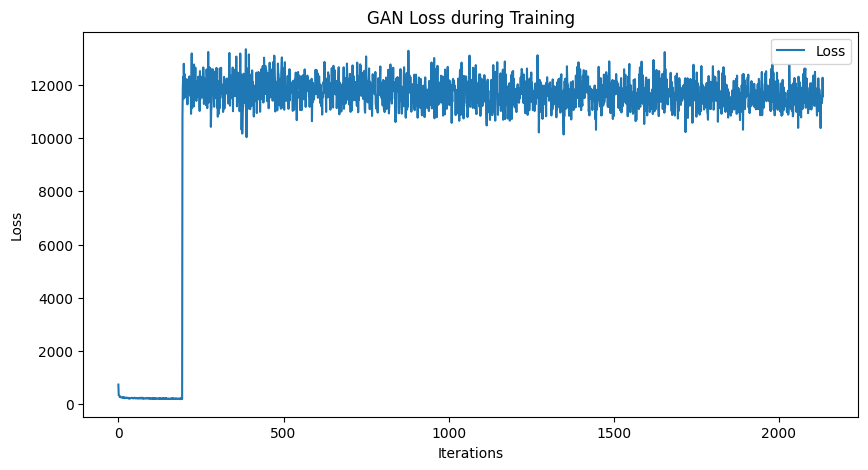

In [192]:
plt.figure(figsize=(10, 5))
plt.title("GAN Loss during Training")
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation of the model

In [193]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            data = data.view(data.size(0), -1)
            recon_batch, mu, logvar = model(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            #if i == 0:
            #    n = min(data.size(0), 5)
            #    comparison = torch.cat([data[:n],recon_batch.view(-1, 1, 28, 28)[:n]])
            #    save_image(comparison.cpu(),'reconstruction_' + str(f"{epoch:02}") + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Test du modèle

In [197]:
test(epoch)

====> Test set loss: 185.5615


Géneration d'image avec le décodeur du cVAE

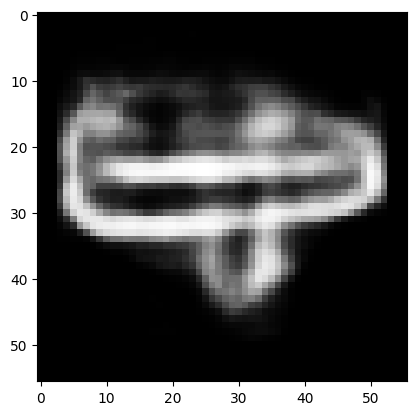

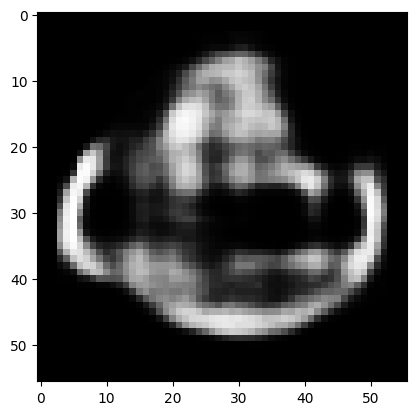

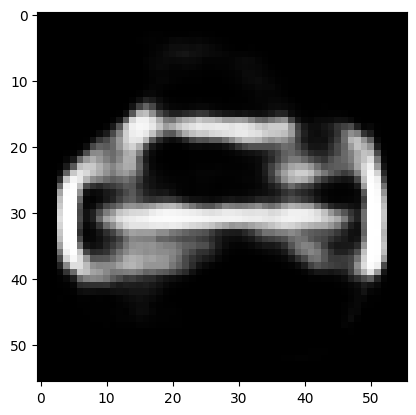

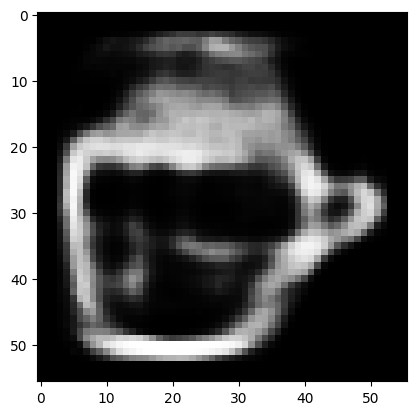

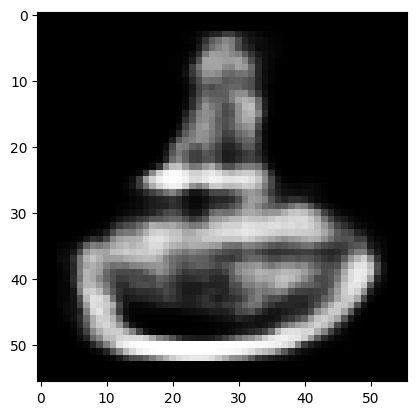

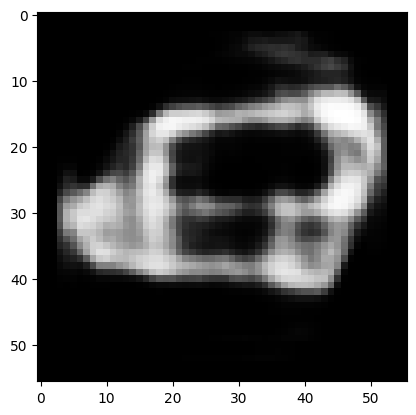

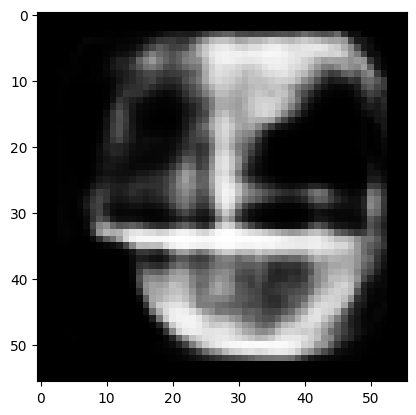

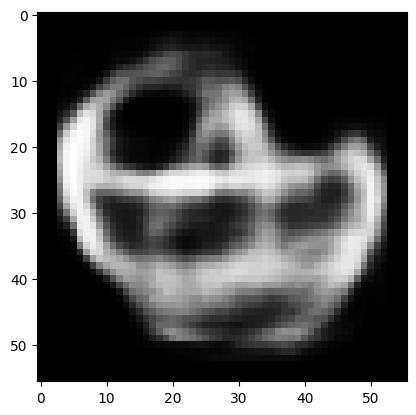

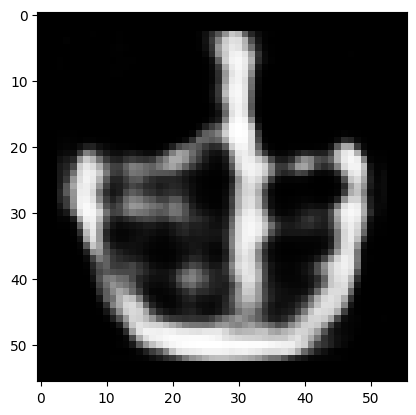

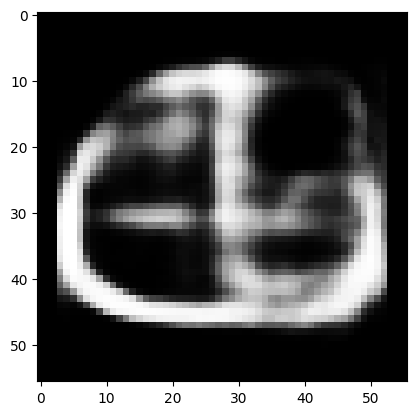

In [195]:
with torch.no_grad():
    c = torch.eye(10, 5).cuda()
    sample = torch.randn(10, latent_dim).to(device)
    sample = model.decode(sample, c).cpu()
    for i in range(10):
        plt.imshow(sample[i].reshape(56, 56), cmap='gray')
        plt.show()

# Save of the best model

In [196]:
# Save the generator model
torch.save(model.state_dict(), '/content/drive/MyDrive/Quickdraw/models/cVAE.h5')